In [1]:

import os
import sys
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from itertools import product
from sklearn.preprocessing import RobustScaler, LabelEncoder

sys.path.extend([
                '../src',
                '../data',
                ])

from utils import run_nested_cv_3b

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("CPU")
    
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#data
left = pd.read_csv('../data/left.csv')
right = pd.read_csv('../data/right.csv')
affected = pd.read_csv('../data/affected.csv')
unaffected = pd.read_csv('../data/unaffected.csv')

#limb
right['limb'] = 1
left['limb'] = 2
affected['limb'] = 3
unaffected['limb'] = 4

affected['subject'] = affected['subject'] + 10
unaffected['subject'] = unaffected['subject'] + 10

le = LabelEncoder()
right['use_type_encoded'] = le.fit_transform(right['use_type'])
left['use_type_encoded'] = le.fit_transform(left['use_type'])
affected['use_type_encoded'] = le.fit_transform(affected['use_type'])
unaffected['use_type_encoded'] = le.fit_transform(unaffected['use_type'])

combined = pd.concat([unaffected, 
                      affected, 
                      right, 
                      left], ignore_index=True)

architecture = {
                'num_filters': [50, 25],
                'filter_sizes': [5, 5],
                'pool_sizes': [5, 5]
               }

CPU


2025-07-10 21:58:20.959336: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.132
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.248


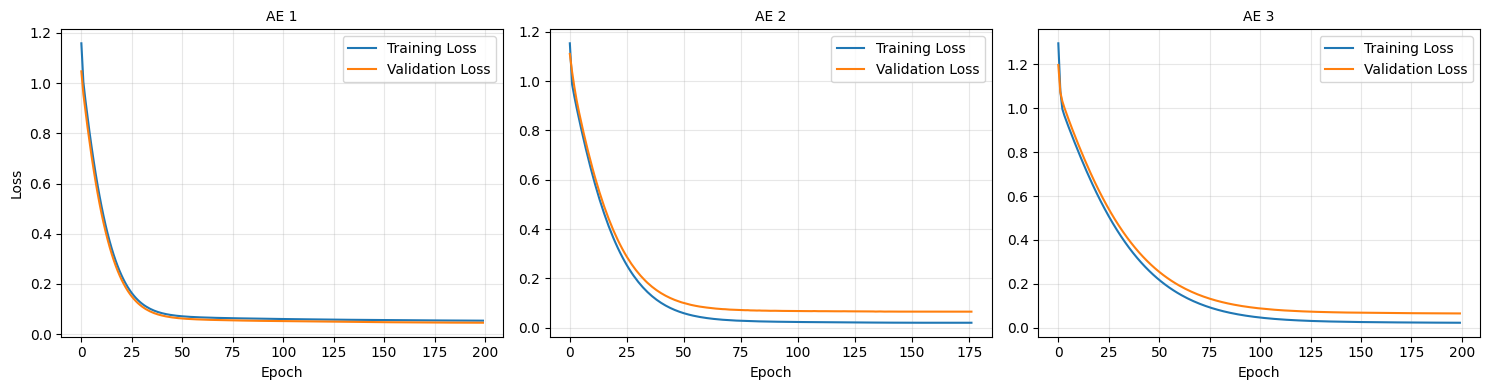

Limb: 1 Subject: 1 Youden Index: 0.20280612244897966 Sensitivity: 0.9319727891156463 Specificity: 0.2708333333333333
Limb: 2 Subject: 1 Youden Index: 0.13978494623655902 Sensitivity: 1.0 Specificity: 0.13978494623655913
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.097
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.264


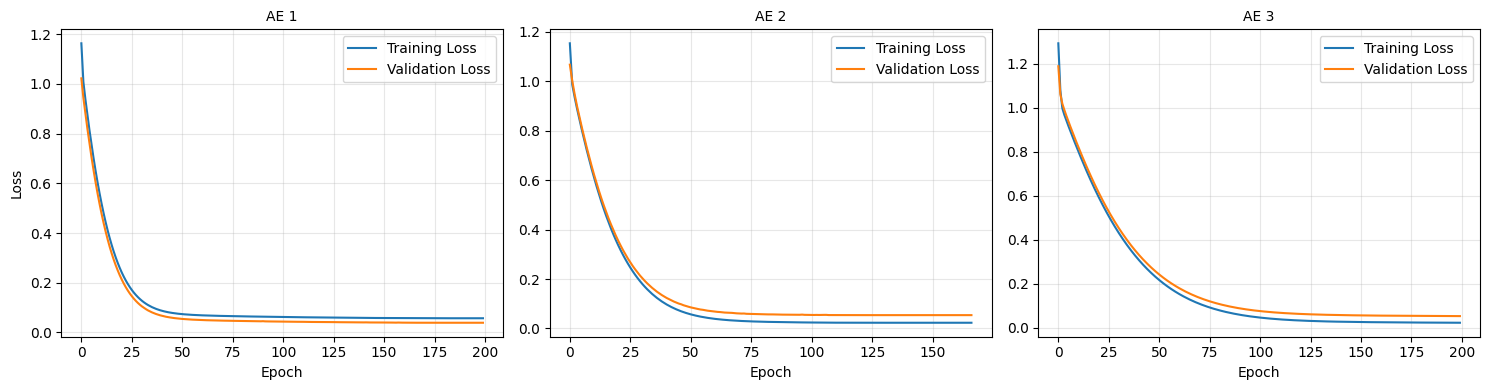

Limb: 1 Subject: 2 Youden Index: 0.14973763118440786 Sensitivity: 0.9945652173913043 Specificity: 0.15517241379310345
Limb: 2 Subject: 2 Youden Index: 0.12857142857142856 Sensitivity: 1.0 Specificity: 0.12857142857142856
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.089
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.250


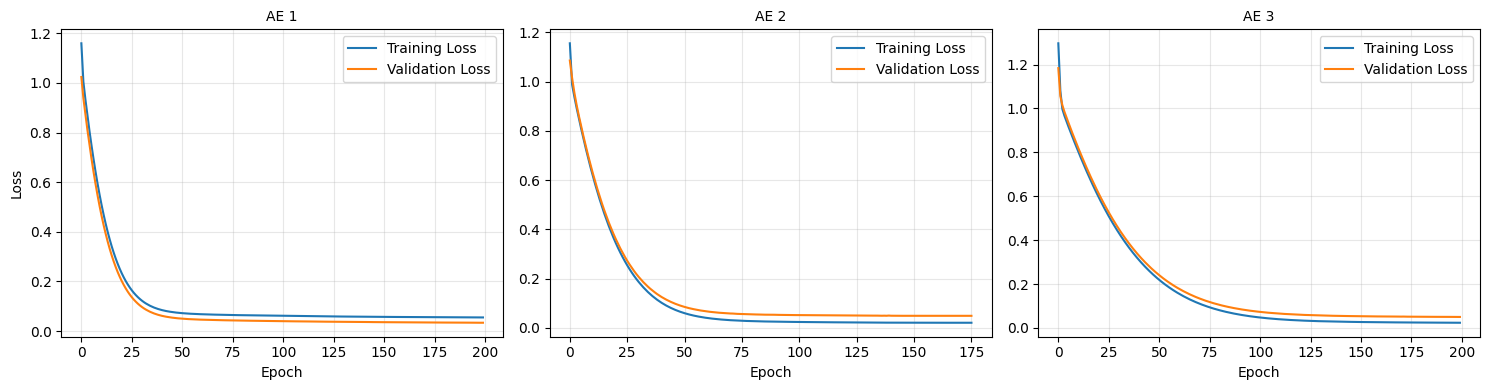

Limb: 1 Subject: 3 Youden Index: 0.36956521739130443 Sensitivity: 0.9347826086956522 Specificity: 0.43478260869565216
Limb: 2 Subject: 3 Youden Index: 0.2350746268656716 Sensitivity: 0.9850746268656716 Specificity: 0.25
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.085
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.245


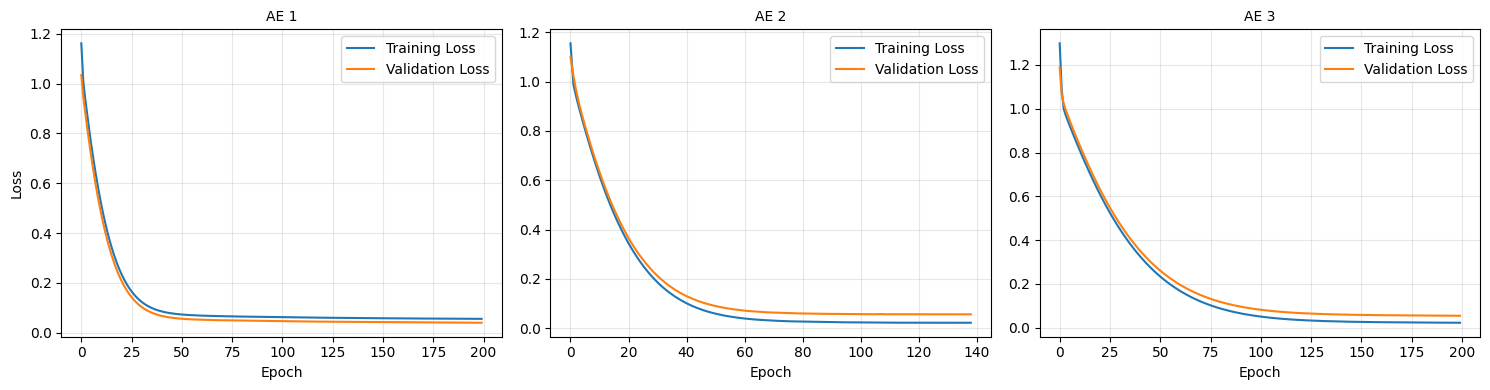

Limb: 1 Subject: 4 Youden Index: 0.5578313253012048 Sensitivity: 0.9578313253012049 Specificity: 0.6
Limb: 2 Subject: 4 Youden Index: 0.2163807415605976 Sensitivity: 0.9856115107913669 Specificity: 0.23076923076923078
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.079
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.252


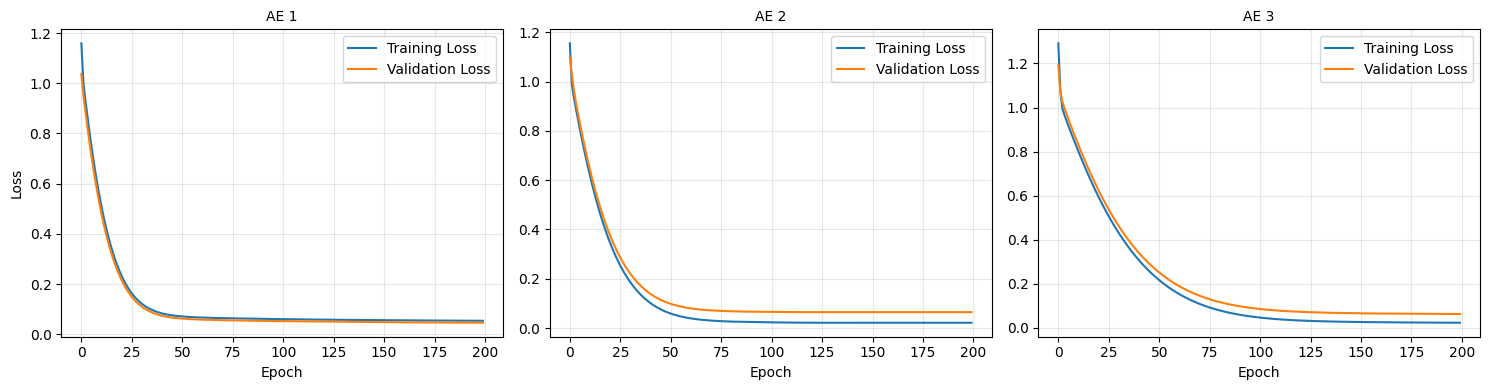

Limb: 1 Subject: 5 Youden Index: 0.37351190476190466 Sensitivity: 0.96875 Specificity: 0.40476190476190477
Limb: 2 Subject: 5 Youden Index: 0.2749999999999999 Sensitivity: 1.0 Specificity: 0.275
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.090
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.245


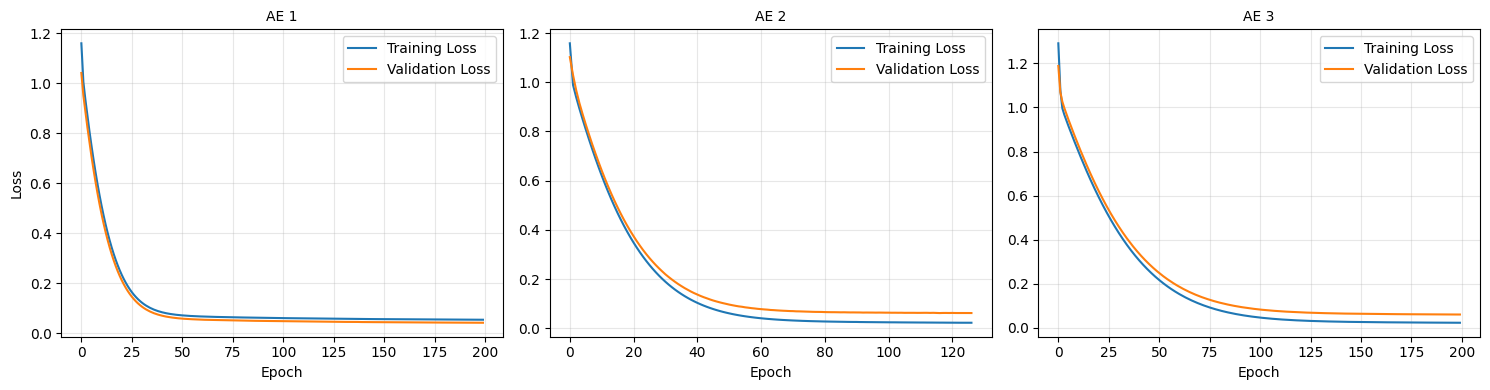

Limb: 1 Subject: 6 Youden Index: 0.1637001429128233 Sensitivity: 0.9776536312849162 Specificity: 0.18604651162790697
Limb: 2 Subject: 6 Youden Index: 0.10825584317667758 Sensitivity: 0.9017341040462428 Specificity: 0.20652173913043478
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.107
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.264


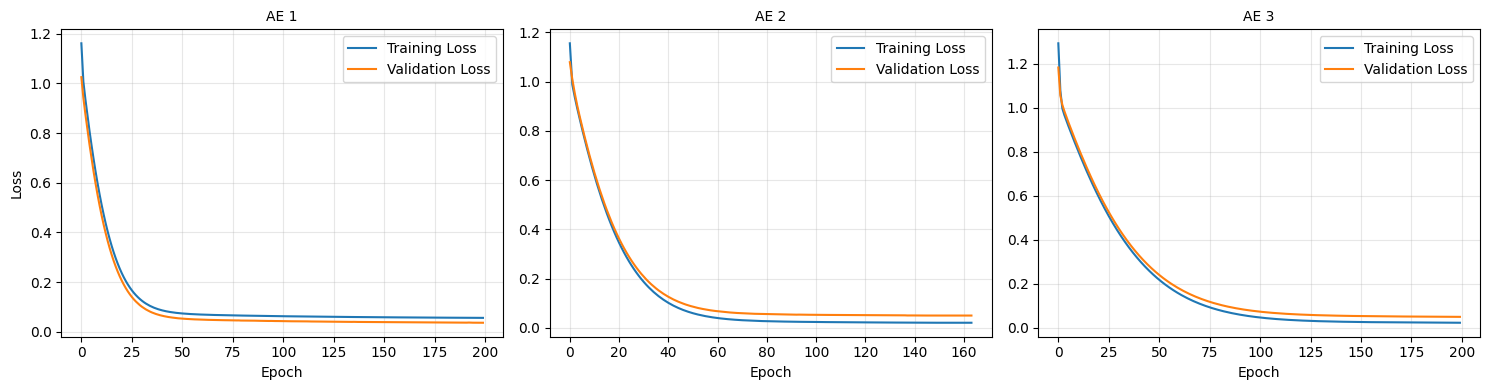

Limb: 1 Subject: 7 Youden Index: 0.20429874077290489 Sensitivity: 0.9489795918367347 Specificity: 0.2553191489361702
Limb: 2 Subject: 7 Youden Index: 0.15708812260536398 Sensitivity: 0.9793103448275862 Specificity: 0.17777777777777778
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.077
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.258


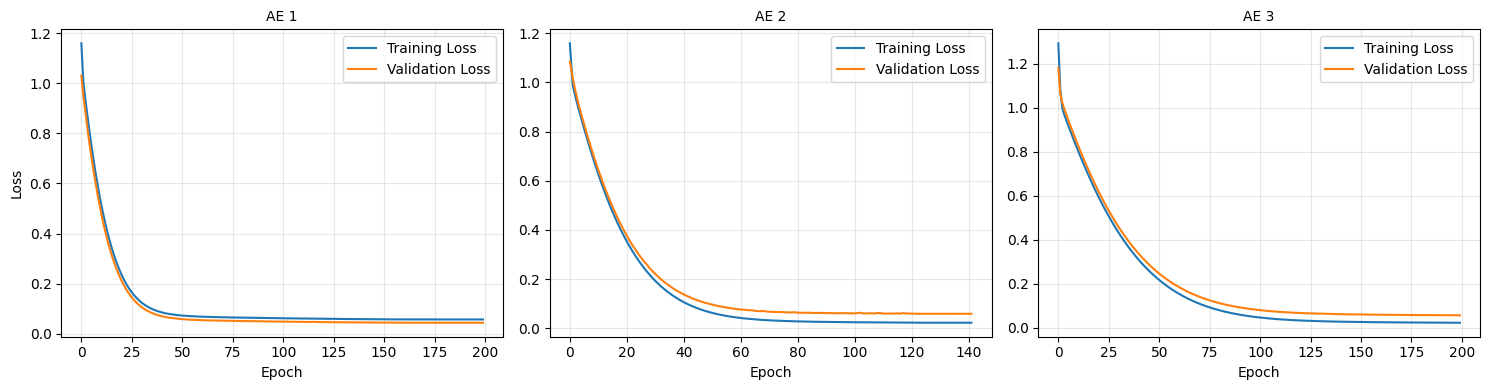

Limb: 1 Subject: 8 Youden Index: 0.2624102870813396 Sensitivity: 0.9186602870813397 Specificity: 0.34375
Limb: 2 Subject: 8 Youden Index: 0.23090005232862376 Sensitivity: 0.9744897959183674 Specificity: 0.2564102564102564
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.106
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.265


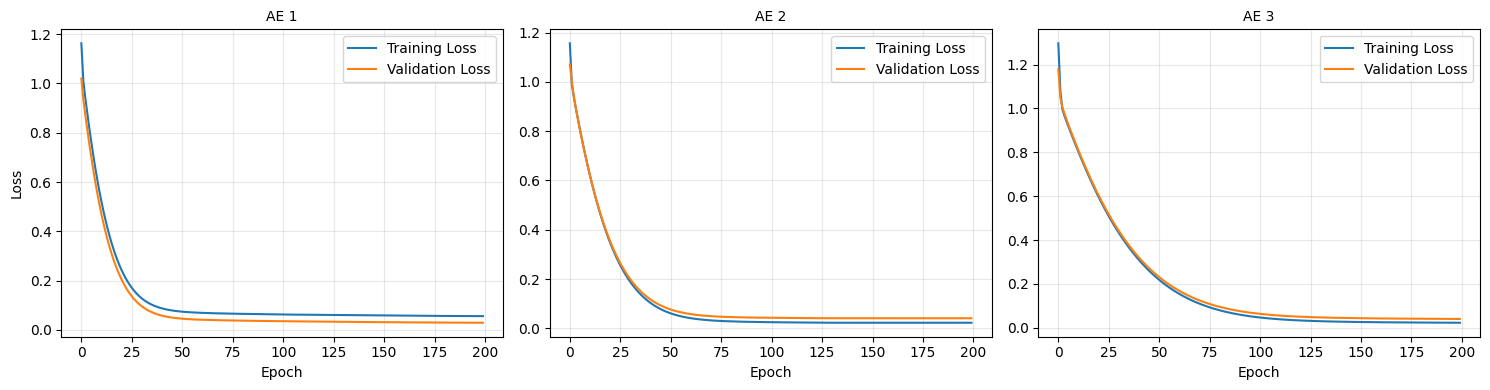

Limb: 1 Subject: 9 Youden Index: 0.07144110935580139 Sensitivity: 0.8862559241706162 Specificity: 0.18518518518518517
Limb: 2 Subject: 9 Youden Index: 0.2547169811320755 Sensitivity: 1.0 Specificity: 0.25471698113207547
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.107
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.243


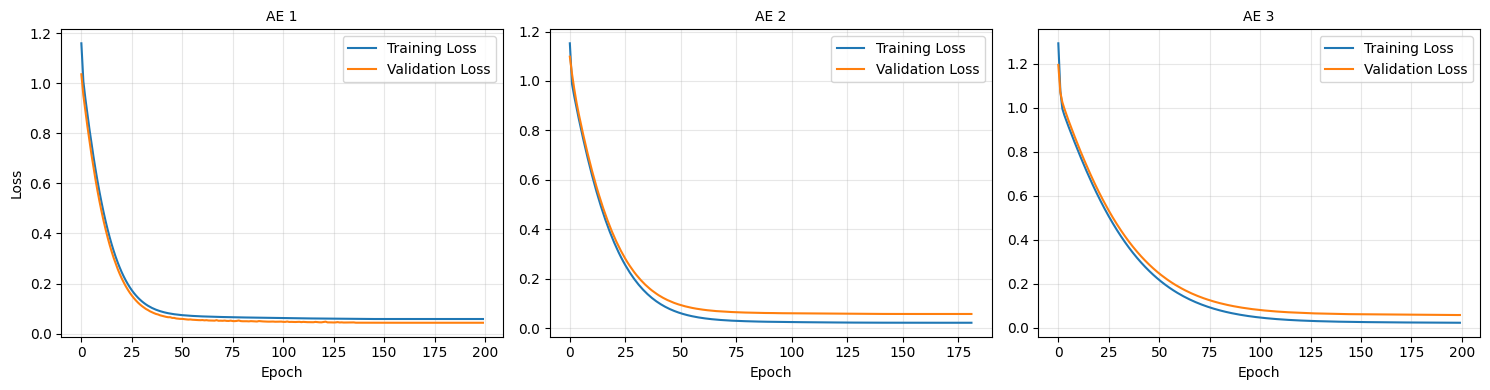

Limb: 1 Subject: 10 Youden Index: 0.36901197604790426 Sensitivity: 0.9940119760479041 Specificity: 0.375
Limb: 2 Subject: 10 Youden Index: 0.18069641649763368 Sensitivity: 0.9852941176470589 Specificity: 0.19540229885057472
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.094
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.233


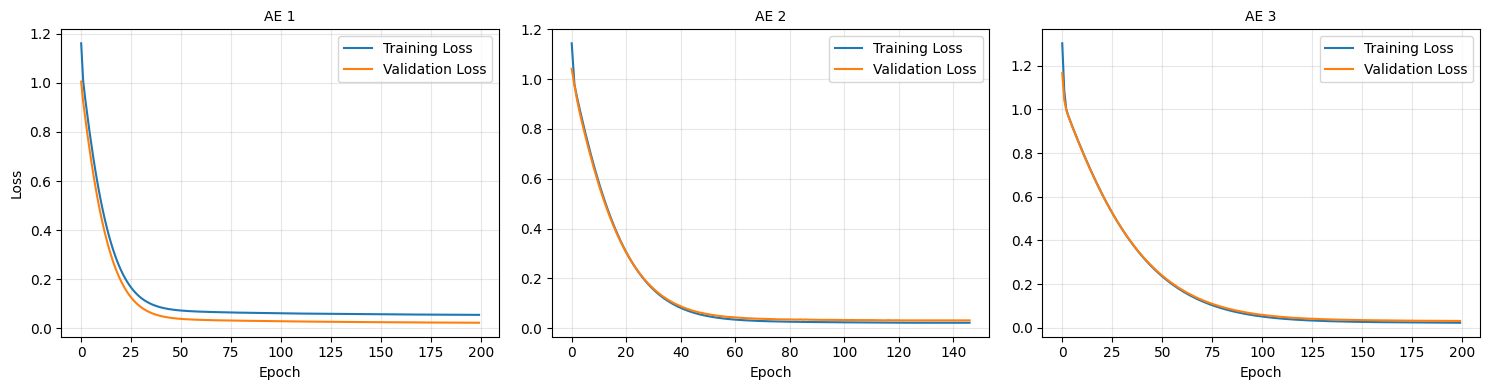

Limb: 3 Subject: 11 Youden Index: 0.18421052631578938 Sensitivity: 1.0 Specificity: 0.18421052631578946
Limb: 4 Subject: 11 Youden Index: 0.554112554112554 Sensitivity: 0.9404761904761905 Specificity: 0.6136363636363636
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.135
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.263


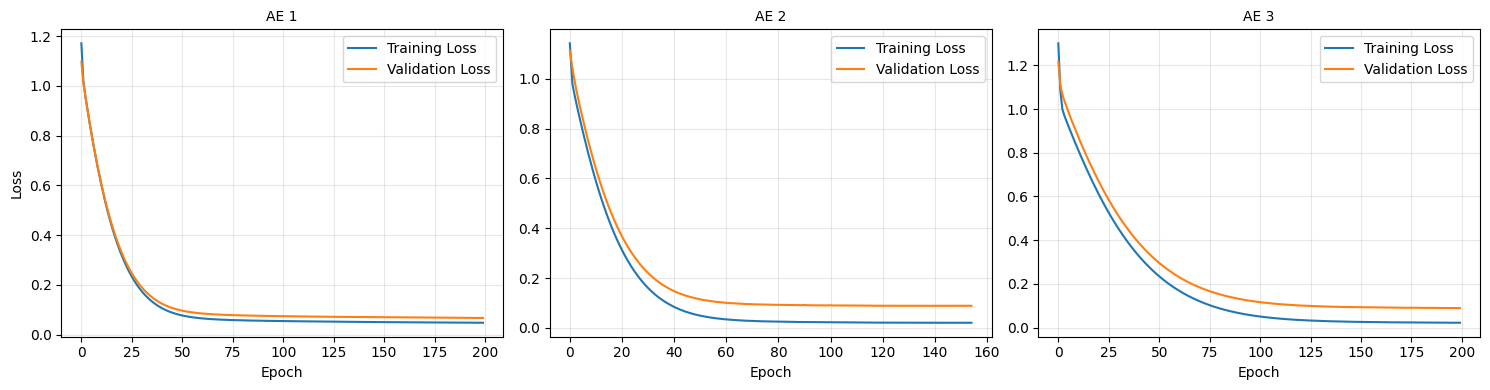

Limb: 3 Subject: 12 Youden Index: 0.15545225338796098 Sensitivity: 0.9580838323353293 Specificity: 0.19736842105263158
Limb: 4 Subject: 12 Youden Index: 0.6165157269451749 Sensitivity: 0.9815950920245399 Specificity: 0.6349206349206349
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.142
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.265


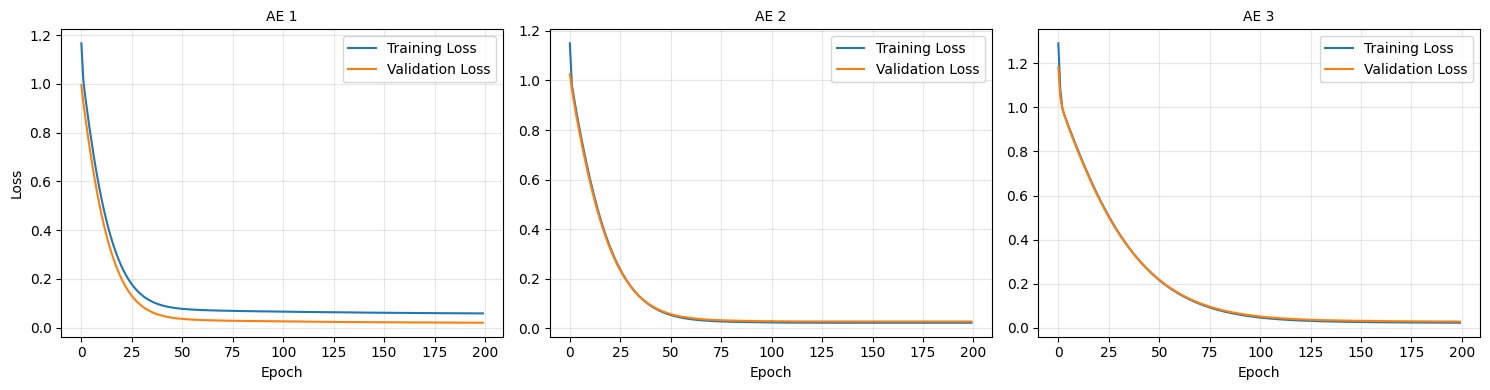

Limb: 3 Subject: 13 Youden Index: 0.034615384615384714 Sensitivity: 0.9846153846153847 Specificity: 0.05
Limb: 4 Subject: 13 Youden Index: -0.021935775667119017 Sensitivity: 0.9477611940298507 Specificity: 0.030303030303030304
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.116
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.253


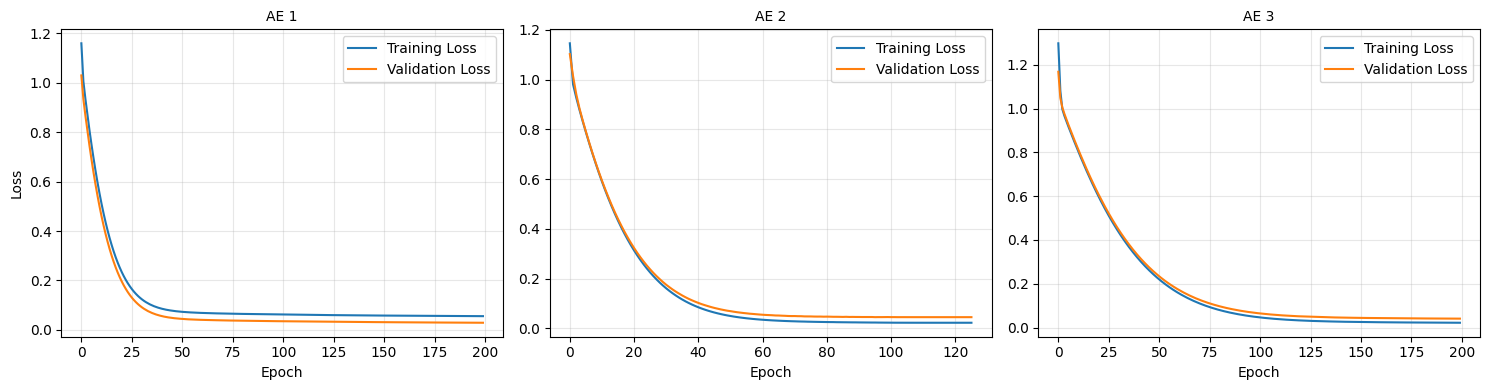

Limb: 3 Subject: 14 Youden Index: 0.35897435897435903 Sensitivity: 1.0 Specificity: 0.358974358974359
Limb: 4 Subject: 14 Youden Index: 0.41716968477531857 Sensitivity: 0.9523809523809523 Specificity: 0.4647887323943662
New best HP found: {'activation': 'tanh', 'batch_norm': True, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.055
New best HP found: {'activation': 'tanh', 'batch_norm': False, 'bias_init': <keras.initializers.initializers_v2.Zeros object at 0x33afff9a0>, 'kernel_init': <keras.initializers.initializers_v2.GlorotNormal object at 0x33afff7c0>, 'learning_rate': 0.0001, 'loss': <function mean_squared_error at 0x1642d6550>, 'optimizer': 'nadam'} with score: 0.247


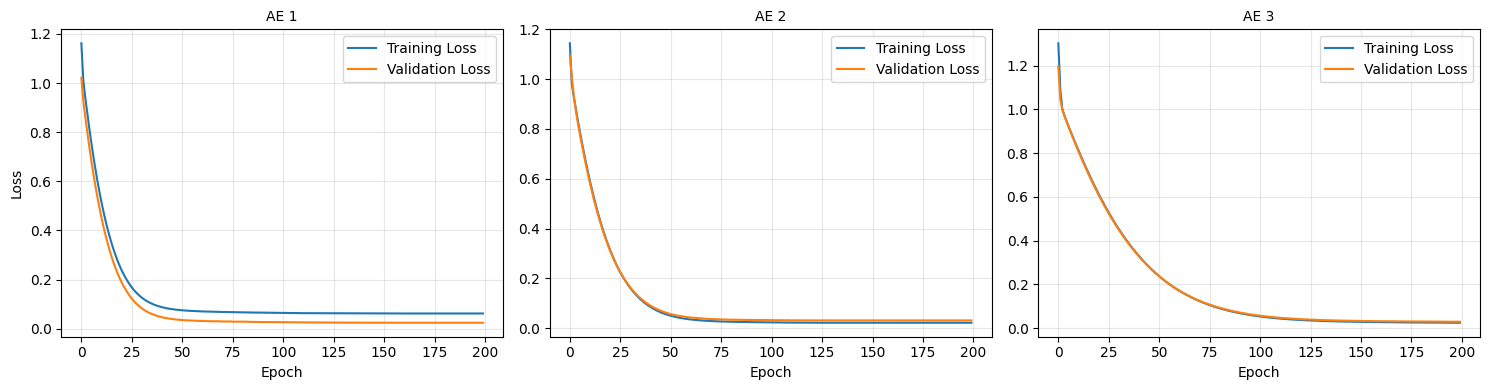

Limb: 3 Subject: 15 Youden Index: 0.40594059405940586 Sensitivity: 1.0 Specificity: 0.40594059405940597
Limb: 4 Subject: 15 Youden Index: 0.1170212765957448 Sensitivity: 1.0 Specificity: 0.11702127659574468


In [2]:


approach = 3
filename = f'../results/approach3b/limb_nested_cv_generic.csv'

window_size = 100
epochs = 200
batch_size = 32
class_loss = False
plot_hist = True

error_func = 'mae'

X = combined[['ax', 'ay', 'az']]
y = combined['gnd']
subjects = combined['subject']
limbs = combined['limb']
usetypes = combined['use_type_encoded']

hp_grid = {
    'activation': ['tanh'],
    'kernel_init': [tf.keras.initializers.GlorotNormal(seed=42), ],           
    'bias_init': [tf.keras.initializers.Zeros()],
    'optimizer': ['nadam'],
    'loss': [tf.keras.losses.mean_squared_error, ],     
    'learning_rate': [0.0001],
    'batch_norm': [True, False]
    }

results_3b = run_nested_cv_3b(
    window_size,             
    X=X,                         
    y=y,                        
    subjects=subjects,           
    limbs=limbs,               
    usetypes=usetypes,          
    architecture=architecture,  
    hp_grid=hp_grid,
    epochs=epochs,                  
    batch_size=batch_size,              
    class_loss=False,           
    plot_hist=True,            
    error_func='None'
)


In [3]:
print("\nResults Summary:")
print(results_3b.groupby(['limb']).agg({
    'youden_index': ['mean', 'std'],
    'sensitivity': ['mean', 'std'],
    'specificity': ['mean', 'std']
}).round(3))


Results Summary:
     youden_index        sensitivity        specificity       
             mean    std        mean    std        mean    std
limb                                                          
1           0.272  0.144       0.951  0.034       0.321  0.138
2           0.193  0.058       0.981  0.029       0.211  0.051
3           0.228  0.153       0.989  0.018       0.239  0.144
4           0.337  0.278       0.964  0.025       0.372  0.282
